In [87]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from PIL import Image
from scipy.stats import gaussian_kde
from sklearn import cluster, decomposition, manifold, metrics, mixture, preprocessing

Function to read the images and convert them to 5D vectors for each pixel:

In [2]:
def readImg(imgPath):
    img = Image.open(imgPath)
    pixels = img.convert('RGB')
    colours = np.array(pixels.getdata()).reshape(img.size + (3,))
    indicesArray = np.moveaxis(np.indices(img.size), 0, 2)
    allArray = np.dstack((indicesArray, colours)).reshape((-1, 5))

    df = pd.DataFrame(allArray, columns = ['y', 'x', 'r', 'g', 'b'])
    df = df[['x', 'y', 'r', 'g', 'b']]  # reorder columns
    return df

In [3]:
images = [os.getcwd() + '/Images/42049_colorBird.jpg', os.getcwd() + '/Images/3096_colorPlane.jpg']  # images are in a dir called Images
bird = readImg(images[0])
plane = readImg(images[1])
print(bird.shape, plane.shape)

(154401, 5) (154401, 5)


Function to normalise the dataframes:

In [4]:
def normalise(df):
    vals = df.values
    scaler = preprocessing.MinMaxScaler()
    scaled = scaler.fit_transform(vals)
    df = pd.DataFrame(scaled, columns = bird.columns)
    return df

In [6]:
bird = normalise(bird)
plane = normalise(plane)

Create a random sample **without** replacement:

In [7]:
def randomSample(df, frac):
    return df.sample(frac = frac, replace = False, random_state = 1)

In [56]:
f = 5000 / bird.shape[0]  # fraction of samples
birdSample = randomSample(bird, f)
planeSample = randomSample(plane, f)
print(birdSample.shape, planeSample.shape)

(5000, 5) (5000, 5)


In [57]:
print('Fraction of samples taken:', f * 100 ,'%')

Fraction of samples taken: 3.238320995330341 %


PCA:

In [10]:
def pcaCalc(df):
    pca = decomposition.PCA(n_components = 5)
    pc = pca.fit_transform(df.values)
    return pc, pca.explained_variance_ratio_

PC1, PC2, and PC3 together account for 99.24675619193066 % of the variance, hence we select a 3D subspace


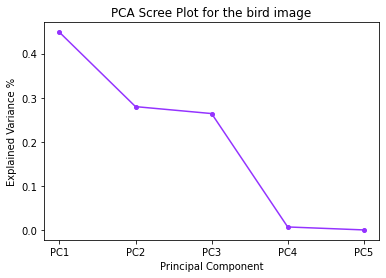

In [32]:
pc, varRatio = pcaCalc(birdSample)
print('PC1, PC2, and PC3 together account for', (varRatio[0] + varRatio[1] + varRatio[2]) * 100, '% of the variance, hence we select a 3D subspace')
plt.plot(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], varRatio, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('PCA Scree Plot for the bird image')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance %')
plt.savefig(os.getcwd() + '/Graphs/pcaScreeBird')
plt.show()
plt.close()

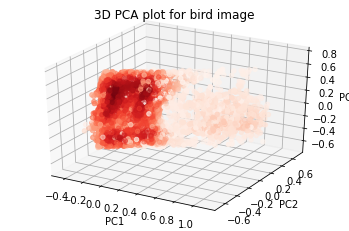

In [36]:
pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
ax = plt.axes(projection = '3d')
density = np.vstack([pc_df['PC1'], pc_df['PC2'], pc_df['PC3']])
z = gaussian_kde(density)(density)
ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c = z, cmap = 'Reds')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA plot for bird image')
plt.savefig(os.getcwd() + '/Graphs/pcaBird')
plt.show()
plt.close()

PC1, PC2, and PC3 together account for 99.42030738438365 % of the variance, hence we select a 3D subspace


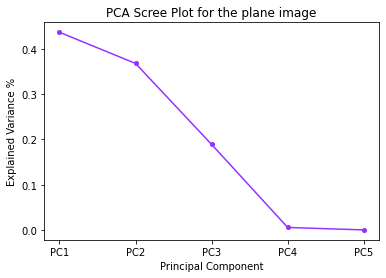

In [38]:
pc, varRatio = pcaCalc(planeSample)
print('PC1, PC2, and PC3 together account for', (varRatio[0] + varRatio[1] + varRatio[2]) * 100, '% of the variance, hence we select a 3D subspace')
plt.plot(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], varRatio, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('PCA Scree Plot for the plane image')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance %')
plt.savefig(os.getcwd() + '/Graphs/pcaScreePlane')
plt.show()
plt.close()

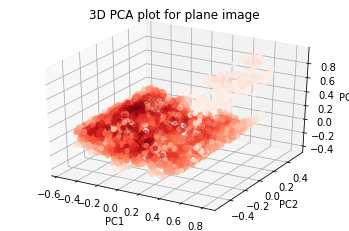

In [39]:
pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
ax = plt.axes(projection = '3d')
density = np.vstack([pc_df['PC1'], pc_df['PC2'], pc_df['PC3']])
z = gaussian_kde(density)(density)
ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c = z, cmap = 'Reds')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA plot for plane image')
plt.savefig(os.getcwd() + '/Graphs/pcaPlane')
plt.show()
plt.close()

t-SNE:

In [41]:
def tsneCalc(df, pplxty):
    dfEmbedded = manifold.TSNE(n_components = 2, perplexity = pplxty).fit_transform(df.values)
    return dfEmbedded

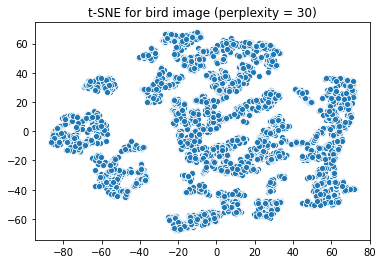

In [43]:
perpl = 30
birdTsne = tsneCalc(birdSample.iloc[:,  : 5], perpl)
sns.scatterplot(birdTsne[:, 0], birdTsne[:, 1])
plt.title('t-SNE for bird image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsneBird' + str(perpl))
plt.show()
plt.close()

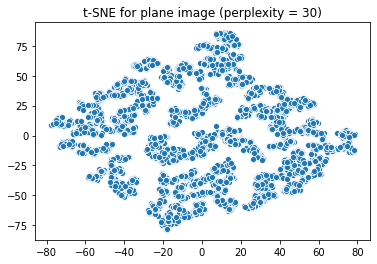

In [46]:
perpl = 30
planeTsne = tsneCalc(planeSample.iloc[:,  : 5], perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsnePlane' + str(perpl))
plt.show()
plt.close()

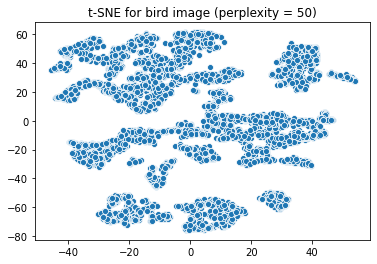

In [47]:
perpl = 50
birdTsne = tsneCalc(birdSample.iloc[:,  : 5], perpl)
sns.scatterplot(birdTsne[:, 0], birdTsne[:, 1])
plt.title('t-SNE for bird image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsneBird' + str(perpl))
plt.show()
plt.close()

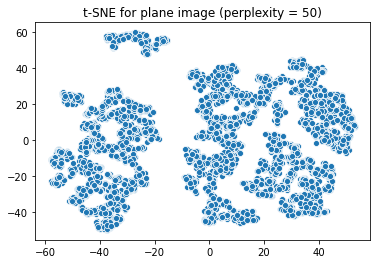

In [49]:
perpl = 50
planeTsne = tsneCalc(planeSample.iloc[:,  : 5], perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsnePlane' + str(perpl))
plt.show()
plt.close()

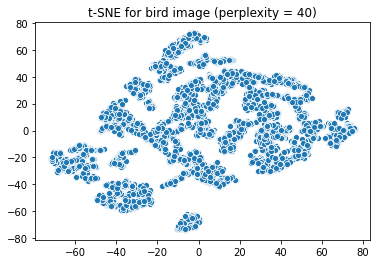

In [50]:
perpl = 40
birdTsne = tsneCalc(birdSample.iloc[:,  : 5], perpl)
sns.scatterplot(birdTsne[:, 0], birdTsne[:, 1])
plt.title('t-SNE for bird image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsneBird' + str(perpl))
plt.show()
plt.close()

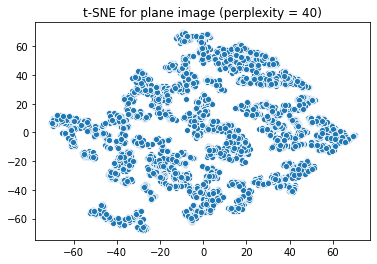

In [51]:
perpl = 40
planeTsne = tsneCalc(planeSample.iloc[:,  : 5], perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsnePlane' + str(perpl))
plt.show()
plt.close()

k-means:

In [52]:
def kmeans(df, k):
    km = cluster.KMeans(n_clusters = k, random_state = 0).fit(df.values)
    return km

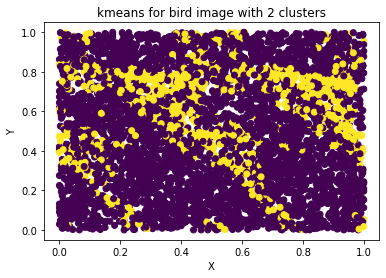

Silhouette score: 0.6147153168862521
CH score: 7348.1012069153185


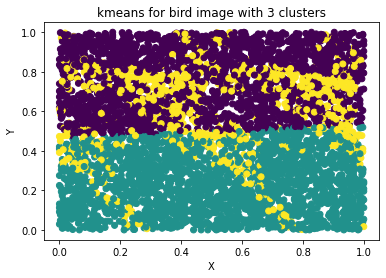

Silhouette score: 0.6385141930003106
CH score: 13351.760319578165


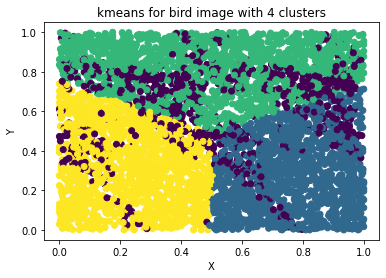

Silhouette score: 0.6885811691141905
CH score: 23083.257829080012


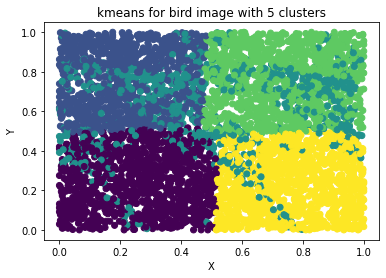

Silhouette score: 0.7162263952283939
CH score: 38750.75830394186


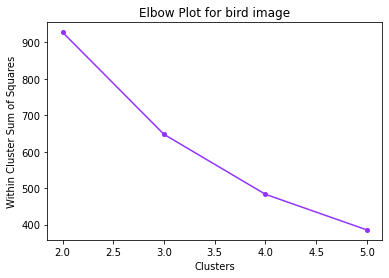

In [62]:
bird_km = []
wcss = []
silhouetteScore = []
chIndex = []

for i in range(2, 6):
    res = kmeans(birdSample.iloc[:,  : 5], i)
    bird_km.append(res)
    birdSample['label'] = res.labels_
    plt.scatter(birdSample['x'], birdSample['y'], c = birdSample['label'])
    plt.title('kmeans for bird image with {} clusters'.format(i))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(os.getcwd() + '/Graphs/kmeansBird' + str(i))
    plt.show()
    plt.close()
    sh = metrics.silhouette_score(birdSample.values, res.labels_)
    silhouetteScore.append(sh)
    print('Silhouette score:', sh)
    ch = metrics.calinski_harabasz_score(birdSample.values, res.labels_)
    chIndex.append(ch)
    print('CH score:', ch)
    
for i in bird_km:
    wcss.append(i.inertia_)

plt.plot([2, 3, 4, 5], wcss, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Elbow Plot for bird image')
plt.xlabel('Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()
plt.close()

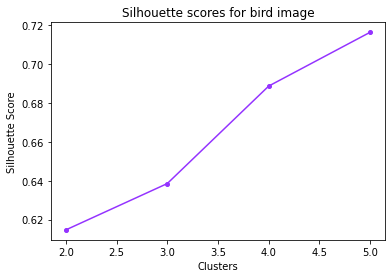

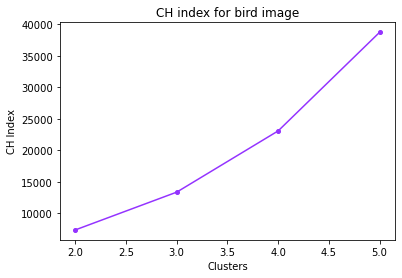

k = 5 gives good clustering


In [63]:
plt.plot([2, 3, 4, 5], silhouetteScore, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Silhouette scores for bird image')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.savefig(os.getcwd() + '/Graphs/shBird')
plt.show()
plt.close()

plt.plot([2, 3, 4, 5], chIndex, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('CH index for bird image')
plt.xlabel('Clusters')
plt.ylabel('CH Index')
plt.savefig(os.getcwd() + '/Graphs/chBird')
plt.show()
plt.close()

print('k = 5 gives good clustering')

In [64]:
birdSample['label'] = bird_km[3].labels_  # adding labels for k = 5 clustering
birdSample.head()

,x,y,r,g,b,label
94059,0.018750,0.610417,0.413934,0.452381,0.392713,2
52923,0.871875,0.341667,0.598361,0.714286,0.724696,4
27628,0.068750,0.179167,0.741803,0.829365,0.789474,0
136771,0.078125,0.887500,0.733607,0.821429,0.781377,1
108806,0.962500,0.704167,0.745902,0.789683,0.773279,3


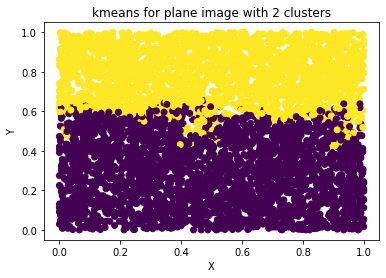

Silhouette score: 0.6159220485179967
CH score: 10560.916617477316


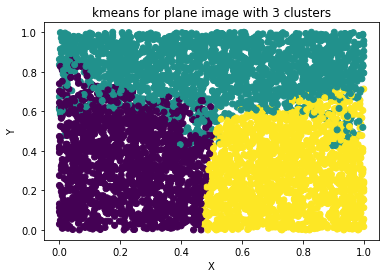

Silhouette score: 0.6723971793721757
CH score: 16520.456815854326


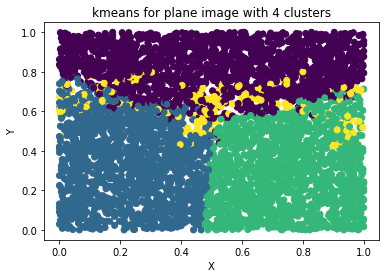

Silhouette score: 0.6973010172919668
CH score: 19908.87921322706


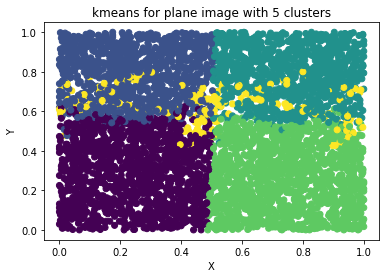

Silhouette score: 0.7315718038557064
CH score: 37773.47338453736


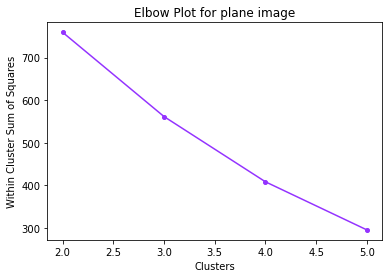

In [65]:
plane_km = []
wcss = []
silhouetteScore = []
chIndex = []

for i in range(2, 6):
    res = kmeans(planeSample.iloc[:,  : 5], i)
    plane_km.append(res)
    planeSample['label'] = res.labels_
    plt.scatter(planeSample['x'], planeSample['y'], c = planeSample['label'])
    plt.title('kmeans for plane image with {} clusters'.format(i))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(os.getcwd() + '/Graphs/kmeansPlane' + str(i))
    plt.show()
    plt.close()
    sh = metrics.silhouette_score(planeSample.values, res.labels_)
    silhouetteScore.append(sh)
    print('Silhouette score:', sh)
    ch = metrics.calinski_harabasz_score(planeSample.values, res.labels_)
    chIndex.append(ch)
    print('CH score:', ch)
    
    
for i in plane_km:
    wcss.append(i.inertia_)

plt.plot([2, 3, 4, 5], wcss, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Elbow Plot for plane image')
plt.xlabel('Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()
plt.close()

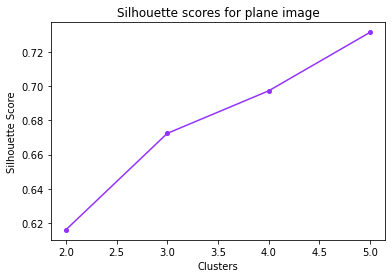

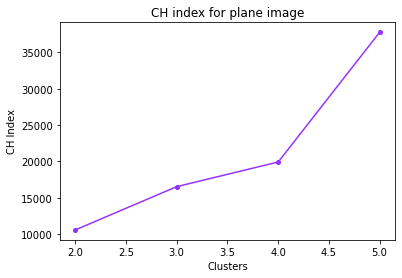

k = 5 gives good clustering


In [68]:
plt.plot([2, 3, 4, 5], silhouetteScore, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Silhouette scores for plane image')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.savefig(os.getcwd() + '/Graphs/shPlane')
plt.show()
plt.close()

plt.plot([2, 3, 4, 5], chIndex, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('CH index for plane image')
plt.xlabel('Clusters')
plt.ylabel('CH Index')
plt.savefig(os.getcwd() + '/Graphs/chPlane')
plt.show()
plt.close()

print('k = 5 gives good clustering')

In [69]:
planeSample['label'] = plane_km[3].labels_  # adding labels for k = 5 clustering
planeSample.head()

,x,y,r,g,b,label
94059,0.018750,0.610417,0.086957,0.115385,0.044693,4
52923,0.871875,0.341667,0.782609,0.780220,0.826816,3
27628,0.068750,0.179167,0.755435,0.758242,0.832402,0
136771,0.078125,0.887500,0.532609,0.582418,0.681564,1
108806,0.962500,0.704167,0.538043,0.587912,0.687151,2


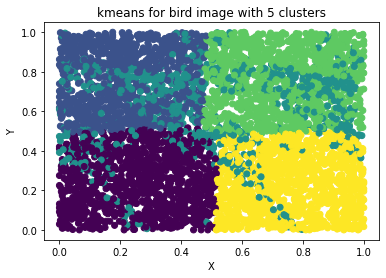

In [85]:
res = kmeans(birdSample.iloc[:,  : 5], 5)
plt.scatter(birdSample['x'], birdSample['y'], c = birdSample['label'])
plt.title('kmeans for bird image with 5 clusters')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig(os.getcwd() + '/Graphs/kmeansLabelBird5')
plt.show()
plt.close()

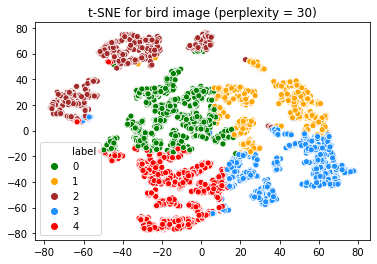

In [70]:
perpl = 30
birdTsne = tsneCalc(birdSample.iloc[:,  : 5], perpl)
sns.scatterplot(birdTsne[:, 0], birdTsne[:, 1], hue = birdSample['label'], palette = ['green','orange','brown','dodgerblue','red'])
plt.title('t-SNE for bird image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsneLabelBird' + str(perpl))
plt.show()
plt.close()

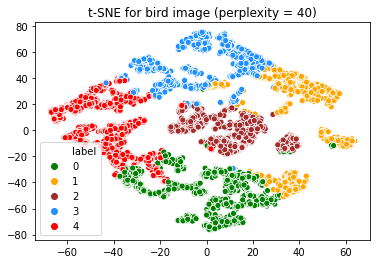

In [71]:
perpl = 40
birdTsne = tsneCalc(birdSample.iloc[:,  : 5], perpl)
sns.scatterplot(birdTsne[:, 0], birdTsne[:, 1], hue = birdSample['label'], palette = ['green','orange','brown','dodgerblue','red'])
plt.title('t-SNE for bird image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsneLabelBird' + str(perpl))
plt.show()
plt.close()

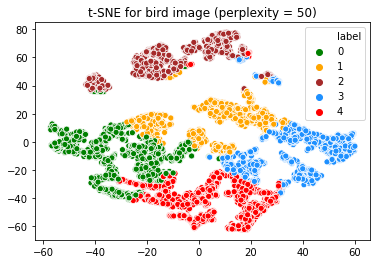

In [72]:
perpl = 50
birdTsne = tsneCalc(birdSample.iloc[:,  : 5], perpl)
sns.scatterplot(birdTsne[:, 0], birdTsne[:, 1], hue = birdSample['label'], palette = ['green','orange','brown','dodgerblue','red'])
plt.title('t-SNE for bird image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsneLabelBird' + str(perpl))
plt.show()
plt.close()

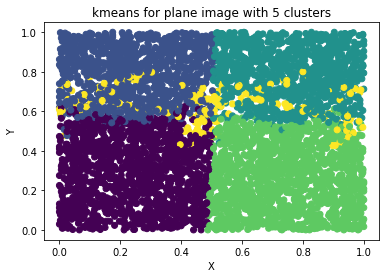

In [86]:
res = kmeans(planeSample.iloc[:,  : 5], 5)
plt.scatter(planeSample['x'], planeSample['y'], c = planeSample['label'])
plt.title('kmeans for plane image with 5 clusters')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig(os.getcwd() + '/Graphs/kmeansLabelPlane5')
plt.show()
plt.close()

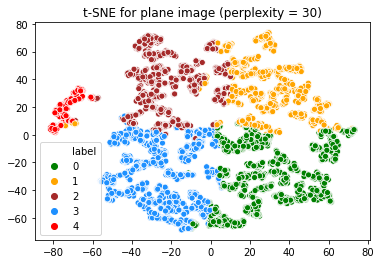

In [73]:
perpl = 30
planeTsne = tsneCalc(planeSample.iloc[:,  : 5], perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1], hue = planeSample['label'], palette = ['green','orange','brown','dodgerblue','red'])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsneLabelPlane' + str(perpl))
plt.show()
plt.close()

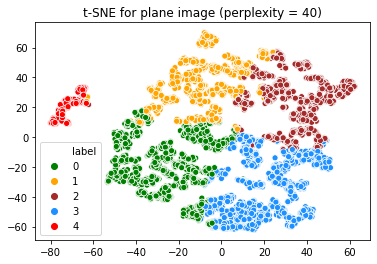

In [74]:
perpl = 40
planeTsne = tsneCalc(planeSample.iloc[:,  : 5], perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1], hue = planeSample['label'], palette = ['green','orange','brown','dodgerblue','red'])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsneLabelPlane' + str(perpl))
plt.show()
plt.close()

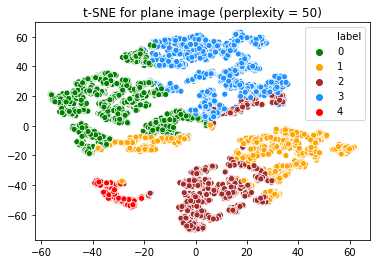

In [75]:
perpl = 50
planeTsne = tsneCalc(planeSample.iloc[:,  : 5], perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1], hue = planeSample['label'], palette = ['green','orange','brown','dodgerblue','red'])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.savefig(os.getcwd() + '/Graphs/tsneLabelPlane' + str(perpl))
plt.show()
plt.close()

GMM-based clustering:

In [93]:
def gmmClustering(df, k):
    gmm = mixture.GaussianMixture(n_components = k, random_state = 0).fit_predict(df.values)
    return gmm

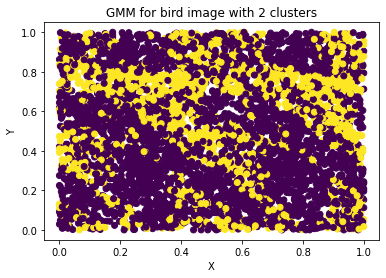

Silhouette score: 0.5610405106562972
CH score: 6712.462012954945


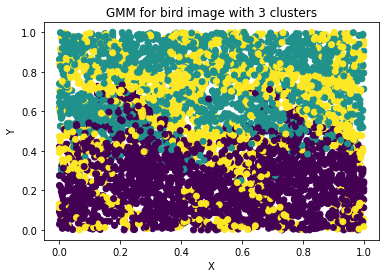

Silhouette score: 0.5896796218253232
CH score: 11804.986479222884


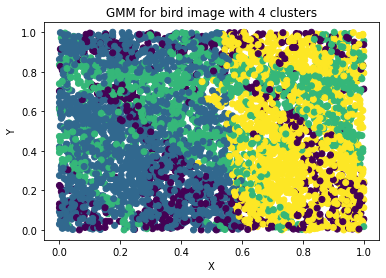

Silhouette score: 0.5989068594695632
CH score: 11572.137622971339


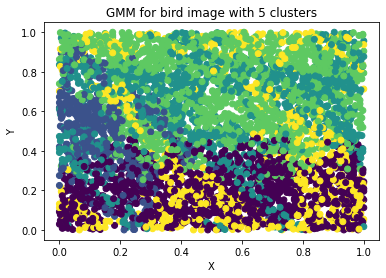

Silhouette score: 0.6029127403673196
CH score: 16193.528865980512


In [98]:
silhouetteScore = []
chIndex = []

for i in range(2, 6):
    birdSample['label'] = gmmClustering(birdSample.iloc[:, : 5], i)
    plt.scatter(birdSample['x'], birdSample['y'], c = birdSample['label'])
    plt.title('GMM for bird image with {} clusters'.format(i))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(os.getcwd() + '/Graphs/gmmBird' + str(i))
    plt.show()
    plt.close()
    sh = metrics.silhouette_score(birdSample.values, birdSample['label'])
    silhouetteScore.append(sh)
    print('Silhouette score:', sh)
    ch = metrics.calinski_harabasz_score(birdSample.values, birdSample['label'])
    chIndex.append(ch)
    print('CH score:', ch)

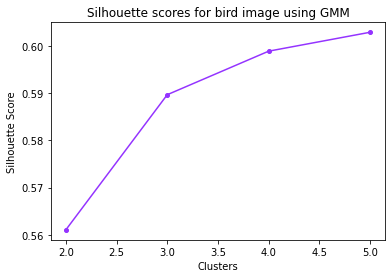

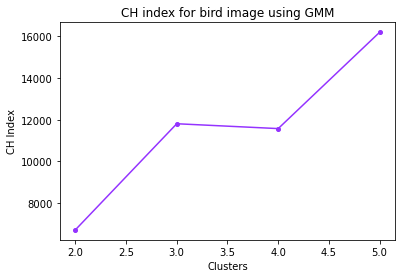

5 components gives good clustering


In [100]:
plt.plot([2, 3, 4, 5], silhouetteScore, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Silhouette scores for bird image using GMM')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.savefig(os.getcwd() + '/Graphs/gmmShBird')
plt.show()
plt.close()

plt.plot([2, 3, 4, 5], chIndex, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('CH index for bird image using GMM')
plt.xlabel('Clusters')
plt.ylabel('CH Index')
plt.savefig(os.getcwd() + '/Graphs/gmmChBird')
plt.show()
plt.close()

print('5 components gives good clustering')

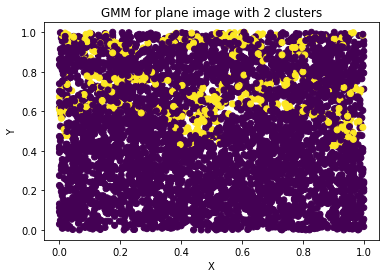

Silhouette score: 0.5856984797865565
CH score: 3407.0207521208335


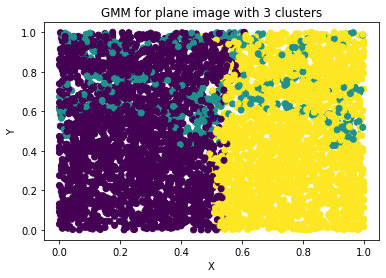

Silhouette score: 0.6594906608681993
CH score: 19003.312676903406


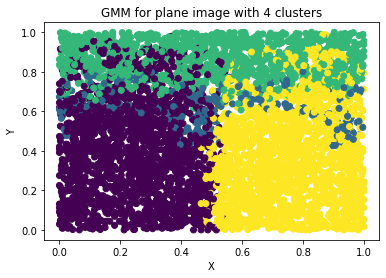

Silhouette score: 0.694410944942528
CH score: 30357.869333203897


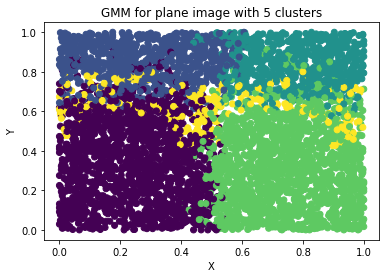

Silhouette score: 0.7115431737436502
CH score: 34480.50901929251


In [106]:
silhouetteScore = []
chIndex = []

for i in range(2, 6):
    planeSample['label'] = gmmClustering(planeSample.iloc[:, : 5], i)
    plt.scatter(planeSample['x'], planeSample['y'], c = planeSample['label'])
    plt.title('GMM for plane image with {} clusters'.format(i))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(os.getcwd() + '/Graphs/gmmPlane' + str(i))
    plt.show()
    plt.close()
    sh = metrics.silhouette_score(planeSample.values, planeSample['label'])
    silhouetteScore.append(sh)
    print('Silhouette score:', sh)
    ch = metrics.calinski_harabasz_score(planeSample.values, planeSample['label'])
    chIndex.append(ch)
    print('CH score:', ch)

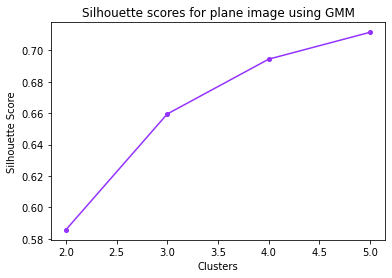

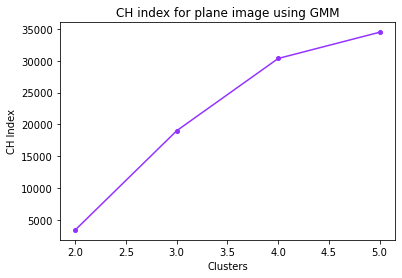

5 components gives good clustering


In [107]:
plt.plot([2, 3, 4, 5], silhouetteScore, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Silhouette scores for plane image using GMM')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.savefig(os.getcwd() + '/Graphs/gmmShPlane')
plt.show()
plt.close()

plt.plot([2, 3, 4, 5], chIndex, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('CH index for plane image using GMM')
plt.xlabel('Clusters')
plt.ylabel('CH Index')
plt.savefig(os.getcwd() + '/Graphs/gmmChPlane')
plt.show()
plt.close()

print('5 components gives good clustering')

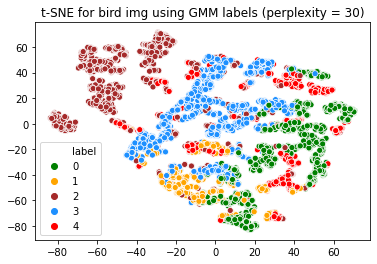

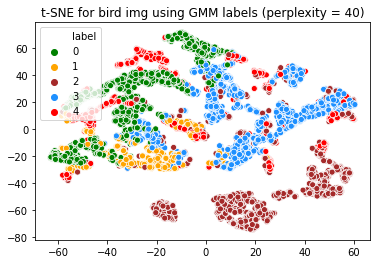

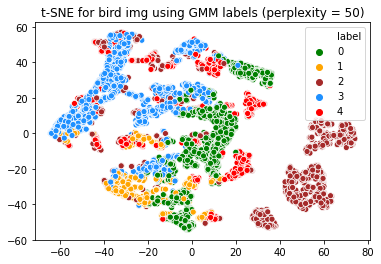

In [110]:
perpl = [30, 40, 50]
for i in perpl:
    birdTsne = tsneCalc(birdSample.iloc[:,  : 5], i)
    sns.scatterplot(birdTsne[:, 0], birdTsne[:, 1], hue = birdSample['label'], palette = ['green','orange','brown','dodgerblue','red'])
    plt.title('t-SNE for bird img using GMM labels (perplexity = {})'.format(str(i)))
    plt.savefig(os.getcwd() + '/Graphs/gmmTsneLabelBird' + str(i))
    plt.show()
    plt.close()

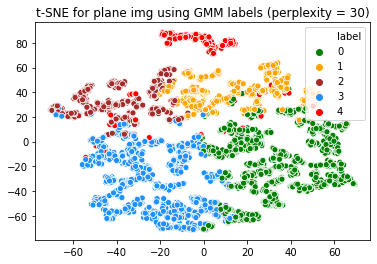

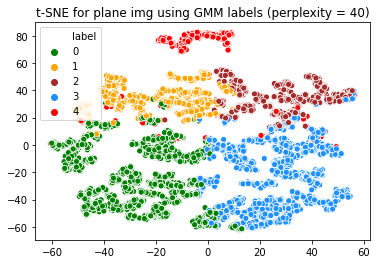

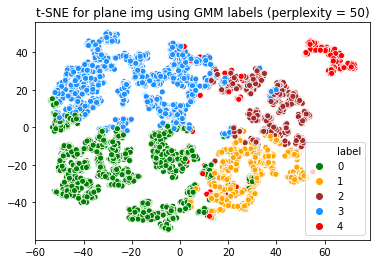

In [111]:
perpl = [30, 40, 50]
for i in perpl:
    planeTsne = tsneCalc(planeSample.iloc[:,  : 5], i)
    sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1], hue = planeSample['label'], palette = ['green','orange','brown','dodgerblue','red'])
    plt.title('t-SNE for plane img using GMM labels (perplexity = {})'.format(str(i)))
    plt.savefig(os.getcwd() + '/Graphs/gmmTsneLabelPlane' + str(i))
    plt.show()
    plt.close()